In [1]:
# !pip install transformers accelerate datasets diffusers Pillow==9.4.0

For Imagenet processing we have to do things a bit different:
* Load recaptioned dataset
* Resize using HF's built-in multiprocessing
* Generate latents in batches
* Reupload to HF

In [1]:
import torchvision.transforms as T
import torch
import random
from datasets import load_dataset, Dataset, DatasetDict
from diffusers import AutoencoderDC
from torch.utils.data import DataLoader
from utils import make_grid, PIL_to_latent, latent_to_PIL, dcae_scalingf
from tqdm import tqdm

from PIL import PngImagePlugin
# otherwise might lead to Decompressed Data Too Large for some images
LARGE_ENOUGH_NUMBER = 10
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Load IN1k recaptions dataset

In [2]:
ds = load_dataset("visual-layer/imagenet-1k-vl-enriched", cache_dir="~/ssd-2TB/hf_cache")

Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/205 [00:00<?, ?it/s]

In [20]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'],
        num_rows: 50000
    })
})

In [3]:
print("splits", ds.keys())
print("features", ds["train"].features.keys())

splits dict_keys(['train', 'validation'])
features dict_keys(['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'])


In [5]:
# # find the one weird image
# image=None

# resizeTo = 96

# def augment(img, do_flip=False, do_contrast=False):
#     def noop(x): return x
#     transform = T.Compose([
#         lambda x: x.convert('RGB') if x.mode!="RGB" else x,
#         T.Resize(resizeTo, antialias=True) if resizeTo is not None else skipT,
#         T.CenterCrop(resizeTo),
#         T.RandomHorizontalFlip(p=1 if do_flip else 0),
#         T.RandomAutocontrast(p=1 if do_contrast else 0),
#     ])
#     return transform(img)

# ds_shuffled = ds["train"].shuffle()

# for row in tqdm(ds_shuffled):
#     image=row["image"]
#     image_aug = augment(image)
    

## Inspect augmentation before actually processing

a tank on display at a museum



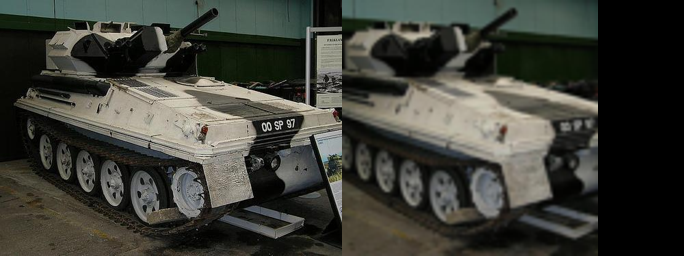

a plate with four figs on it



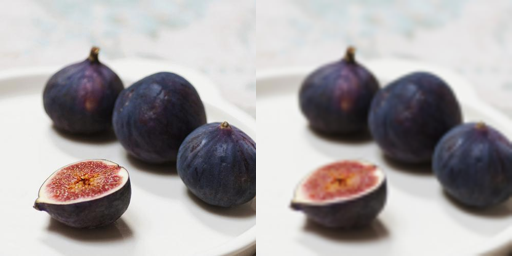

a person holding a small worm in their hand



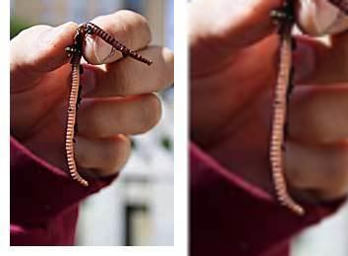

a dog is under a blanket



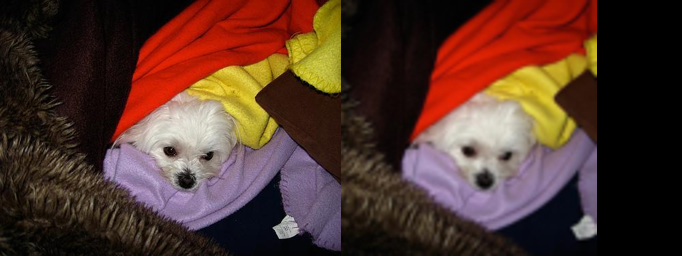

a small dog is playing with a red and blue toy



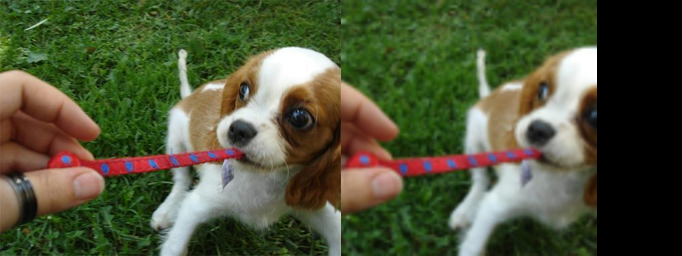

a woman sitting on a hay bale



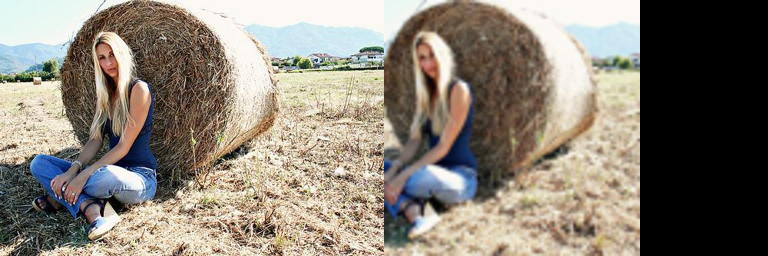

a boat with people on it traveling on the water



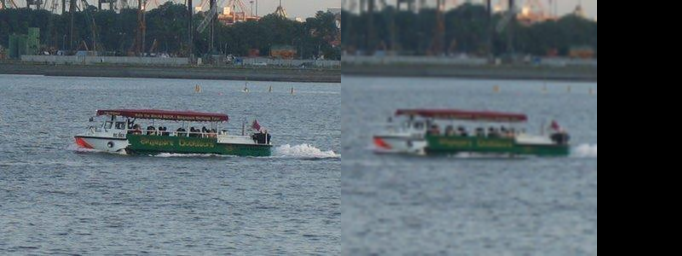

a bathroom with a bath tub and a sink



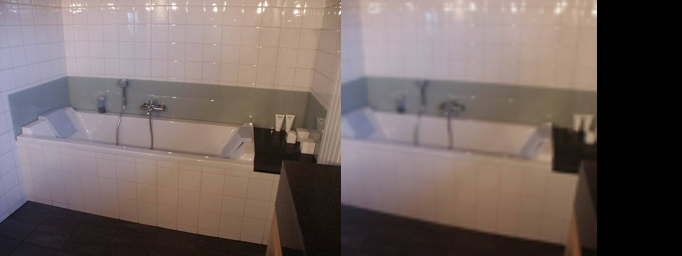

a computer desk with two monitors and a lamp



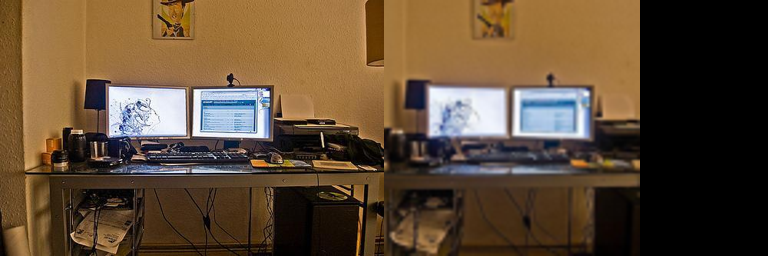

two women wearing masks



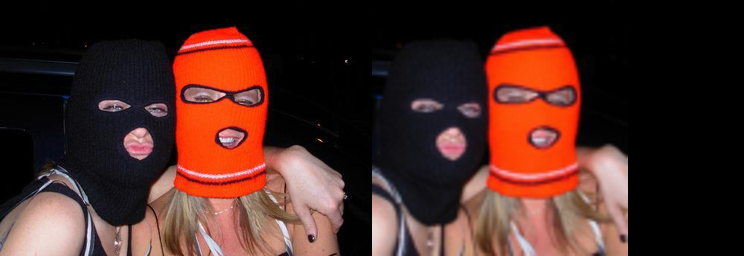

In [4]:
resizeTo = 96
split = "train"

def augment(img, do_flip=False, do_contrast=False):
    def noop(x): return x
    transform = T.Compose([
        lambda x: x.convert('RGB') if x.mode!="RGB" else x,
        T.Resize(resizeTo, antialias=True) if resizeTo is not None else skipT,
        T.CenterCrop(resizeTo),
        T.RandomHorizontalFlip(p=1 if do_flip else 0),
        T.RandomAutocontrast(p=1 if do_contrast else 0),
    ])
    return transform(img)

for i in [random.randint(0, len(ds[split])) for _ in range(10)]:
    img=ds[split][i]["image"]
    label=ds[split][i]["caption_enriched"]
    images = []
    
    images.append( img.resize((round(img.width/img.height*256),256)) )
    images.append( augment(img).resize((256,256)) )
    # images.append( augment(img, do_flip=True).resize((256,256)) )
    # images.append( augment(img, do_contrast=True).resize((256,256)) )
    # images.append( augment(img, do_flip=True, do_contrast=True).resize((256,256)) )

    print(label)
    display(make_grid(images))

# Load DCAE

In [5]:
model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# Batch augment and create dataset

In [6]:
def collate(items):
    labels = [item["caption_enriched"] for item in items]
    images = [augment(item["image"]) for item in items]
    return labels, images

In [9]:
test_run = False
batch_size = 512
resizeTo = 96
dataset_latents = {}
splits=["train", "validation"]

for split in splits:
    # Change the dataset !
    dataloader = DataLoader(
        ds[split], 
        batch_size = batch_size, 
        shuffle=False, 
        collate_fn=collate,
        num_workers=5,
        prefetch_factor=4,
    )
    dataset_latents[split]=[]
    
    for labels, images in tqdm(dataloader, f"split {split}"):
        latents = PIL_to_latent(images, dcae).float().cpu()   # shape [B * latents_per_img, ..., C, W, H]
    
        for i, label in enumerate(labels):
            latent = latents[None, i]
            if test_run: print(latent.shape)
            dataset_latents[split].append({
                "label": label,
                "num_latents": 1,
                "latent": latent 
            })
        if test_run: break

split validation: 100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [01:54<00:00,  1.17s/it]


split train
a circular library with people sitting on a round table
 torch.Size([1, 32, 3, 3])


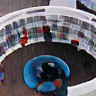

a group of mushrooms on the ground in the forest
 torch.Size([1, 32, 3, 3])


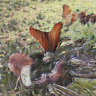

a blue garbage truck parked in front of a building
 torch.Size([1, 32, 3, 3])


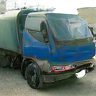

a man holding a large fish on a boat
 torch.Size([1, 32, 3, 3])


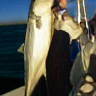

a view of a beach and ocean
 torch.Size([1, 32, 3, 3])


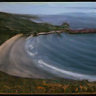

a rayfish swimming in the ocean
 torch.Size([1, 32, 3, 3])


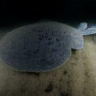

two people playing a game of soccer
 torch.Size([1, 32, 3, 3])


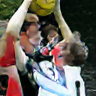

a group of monkeys are sitting on top of a tree
 torch.Size([1, 32, 3, 3])


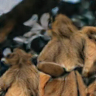

a blue ipod with a message on it
 torch.Size([1, 32, 3, 3])


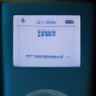

black and white photograph of hay bales in a field
 torch.Size([1, 32, 3, 3])


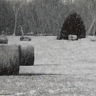

a blue and gray respirator with two filters
 torch.Size([1, 32, 3, 3])


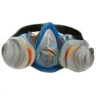

a microphone on a pole with a cord attached
 torch.Size([1, 32, 3, 3])


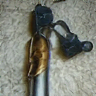

split validation
a bottle of ginger ale sitting on a carpet
 torch.Size([1, 32, 3, 3])


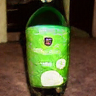

the konichiwa konichiwa konichiwa konichiwa konichi torch.Size([1, 32, 3, 3])


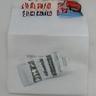

a dog is standing on a balcony
 torch.Size([1, 32, 3, 3])


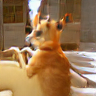

a man is holding a rope and a bear on his shirt
 torch.Size([1, 32, 3, 3])


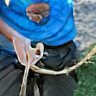

a yellow apple with a pin on it
 torch.Size([1, 32, 3, 3])


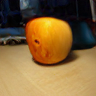

a black and silver crock pot
 torch.Size([1, 32, 3, 3])


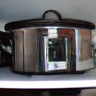

a close up of a metal box with four keys
 torch.Size([1, 32, 3, 3])


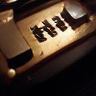

a group of puppies sleeping together
 torch.Size([1, 32, 3, 3])


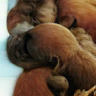

a red and white christmas stocking with a message
 torch.Size([1, 32, 3, 3])


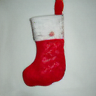

a boat with people on it is going down the water
 torch.Size([1, 32, 3, 3])


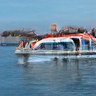

a blue and white slug on a coral reef
 torch.Size([1, 32, 3, 3])


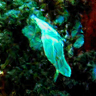

a dog wearing a yellow shirt
 torch.Size([1, 32, 3, 3])


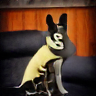

In [10]:
# check a few samples
num_samples = 12
dataset = dataset_latents
for split in dataset_latents:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(num_samples)]:
        latent = torch.Tensor(dataset[split][idx]["latent"])
        label = dataset[split][idx]["label"]
        print(label, latent.shape)
        display(
            # make_grid(
                latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)
            # )
        )

# Upload

In [15]:
a

NameError: name 'a' is not defined

In [14]:
dataset = DatasetDict({
    split: Dataset.from_list(dataset_latents[split]) 
    for split in dataset_latents
})
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'num_latents', 'latent'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['label', 'num_latents', 'latent'],
        num_rows: 50000
    })
})

split train
a monkey with a long white beard sitting on a tree branch
 torch.Size([1, 32, 3, 3])


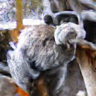

avon lip gloss in pink with black box
 torch.Size([1, 32, 3, 3])


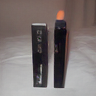

a tennis ball stuck in a tree
 torch.Size([1, 32, 3, 3])


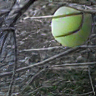

a large eel is laying on the sand
 torch.Size([1, 32, 3, 3])


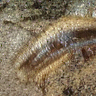

a vintage sewing machine on a wooden table
 torch.Size([1, 32, 3, 3])


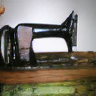

split validation
a computer monitor on a desk
 torch.Size([1, 32, 3, 3])


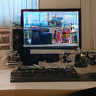

a mushroom on the ground
 torch.Size([1, 32, 3, 3])


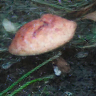

the wing of an airplane
 torch.Size([1, 32, 3, 3])


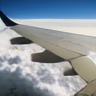

a large stone building
 torch.Size([1, 32, 3, 3])


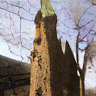

a mannequin wearing a camouflage uniform and helmet
 torch.Size([1, 32, 3, 3])


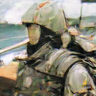

In [17]:
# check a few samples
for split in splits:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(5)]:
        latent = torch.Tensor(dataset[split][idx]["latent"])
        label = dataset[split][idx]["label"]
        print(label, latent.shape)
        display(
            # make_grid(
                latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)
            # )
        )

In [16]:
from local_secrets import hf_token
from huggingface_hub import login
login(token=hf_token)

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'num_latents', 'latent'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['label', 'num_latents', 'latent'],
        num_rows: 50000
    })
})

In [19]:
dataset.push_to_hub(
    "g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0", 
    private=True, 
    commit_message=model,
    num_shards={'train': 10, 'validation': 4}
)

Uploading the dataset shards:   0%|          | 0/10 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/129 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0/commit/87add3f3f2fa73b0f049287b459a0a41450615f4', commit_message='Efficient-Large-Model/Sana_600M_1024px_diffusers', commit_description='', oid='87add3f3f2fa73b0f049287b459a0a41450615f4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0', endpoint='https://huggingface.co', repo_type='dataset', repo_id='g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0'), pr_revision=None, pr_num=None)